In [2]:
import pandas as pd
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords

In [29]:
df = pd.read_csv("../spam.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.size

11144

In [4]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [5]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords


In [6]:
stemmer = nltk.SnowballStemmer("english") #check with other stemmer

In [7]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [9]:
df['message_clean'] = df['message'].apply(preprocess_data)
df.head()

,target,message,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,dun say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though,0


In [12]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

5572 5572


In [13]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics

def conf_matrix(confusion_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix)
    disp.plot()

In [19]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

Train:               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3623
           1       1.00      0.87      0.93       556

    accuracy                           0.98      4179
   macro avg       0.99      0.94      0.96      4179
weighted avg       0.98      0.98      0.98      4179

Test:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1202
           1       0.97      0.77      0.86       191

    accuracy                           0.96      1393
   macro avg       0.97      0.88      0.92      1393
weighted avg       0.96      0.96      0.96      1393



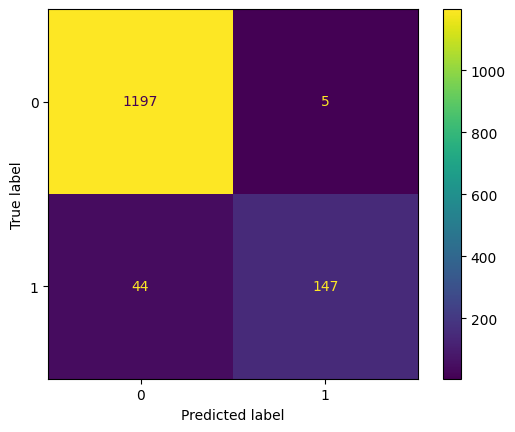

In [20]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(classification_report(y_train, y_pred_train)))
print('Test: {}'.format(classification_report(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

## Test with other dataset

In [48]:
import csv

with open('../SMSSpamCollection.txt.', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split("\t") for line in stripped if line)
    with open('../SMSSpamCollection.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('target', 'message'))
        writer.writerows(lines)

In [49]:
df = pd.read_csv("../SMSSpamCollection.csv")
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [50]:
df['message_clean'] = df['message'].apply(preprocess_data)
df.head()

,target,message,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


In [51]:
df['target_encoded'] = df['target'].map(
    {
        'ham': 0,
        'spam': 1
    }
)

In [52]:
x = df['message_clean']
y = df['target_encoded']

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2 ,random_state=42, stratify=df.target_encoded)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4459 4459
1115 1115


In [54]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

Train:               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3861
           1       1.00      0.85      0.92       598

    accuracy                           0.98      4459
   macro avg       0.99      0.92      0.95      4459
weighted avg       0.98      0.98      0.98      4459

Test:               precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.97      0.81      0.88       149

    accuracy                           0.97      1115
   macro avg       0.97      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



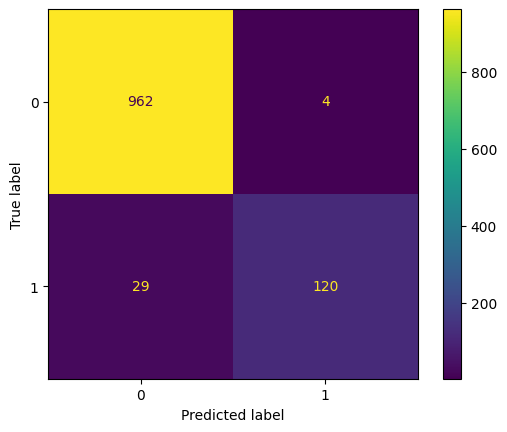

In [55]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(classification_report(y_train, y_pred_train)))
print('Test: {}'.format(classification_report(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))